In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..','..','util'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

c:\users\goofy\anaconda3\envs\d2l\lib\site-packages\nbformat\current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [4]:
import os
import pandas as pd

from DataLoader import fetch_titanic_data

# loading data from MLutil.fetch_titanic_data
train_data = fetch_titanic_data("train.csv")
test_data = fetch_titanic_data("test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Visualizing data

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Null values in age, embarked, and cabin. Ignoring cabin as it has largely consists of null values.

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

plotting correlation matrix

array([[<AxesSubplot:xlabel='Survived', ylabel='Survived'>,
        <AxesSubplot:xlabel='Fare', ylabel='Survived'>,
        <AxesSubplot:xlabel='Age', ylabel='Survived'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Survived'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Fare'>,
        <AxesSubplot:xlabel='Fare', ylabel='Fare'>,
        <AxesSubplot:xlabel='Age', ylabel='Fare'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Fare'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Age'>,
        <AxesSubplot:xlabel='Fare', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Age'>],
       [<AxesSubplot:xlabel='Survived', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Fare', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Age', ylabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass', ylabel='Pclass'>]], dtype=object)

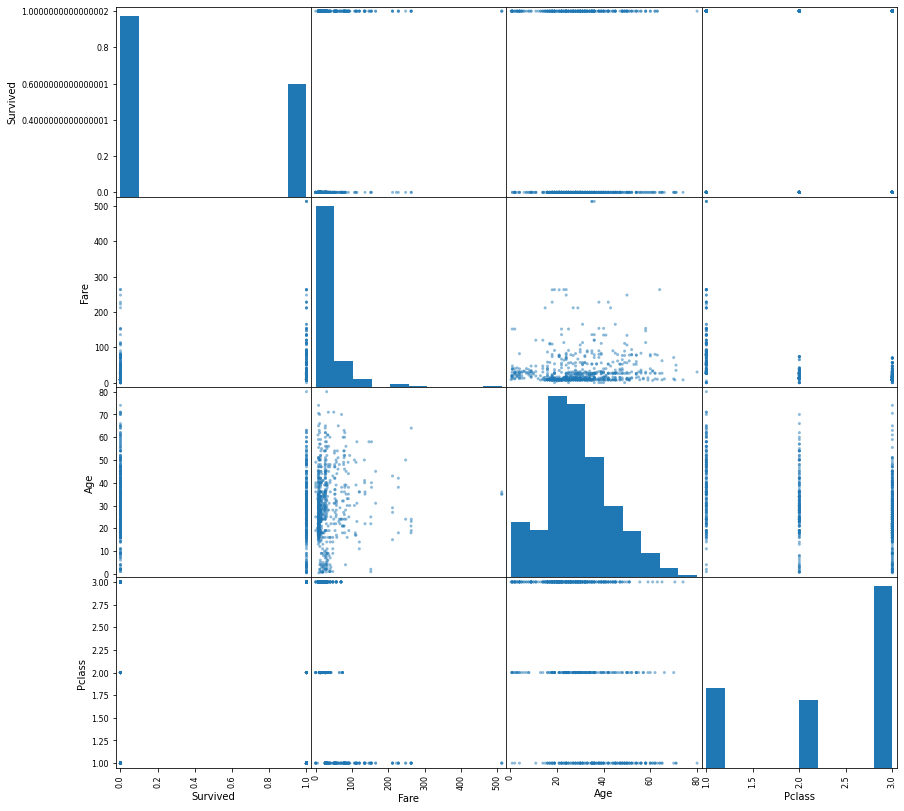

In [8]:
from pandas.plotting import scatter_matrix
attributes = ["Survived", "Cabin", "Embarked","Fare", "Age", "Pclass", "Sex"]
scatter_matrix(train_data[attributes], figsize = (14, 14))

In [9]:
train_data["Survived"].value_counts(),train_data["Pclass"].value_counts(), train_data["Sex"].value_counts(), train_data["Embarked"].value_counts()

(0    549
 1    342
 Name: Survived, dtype: int64,
 3    491
 1    216
 2    184
 Name: Pclass, dtype: int64,
 male      577
 female    314
 Name: Sex, dtype: int64,
 S    644
 C    168
 Q     77
 Name: Embarked, dtype: int64)

## Creating labels

In [10]:
y_train = train_data["Survived"]